In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import pandas as pd
import json
import numpy as np
from sklearn import preprocessing
from torch import nn
from tqdm.notebook import tqdm

import ast

In [2]:
BATCH_SIZE = 2
TRAIN_TEST_SPLIT = 0.9
DS_PATH = "/home/deadman445/PycharmProjects/CuArgPred/data/_all_data2.csv"
EPOCHS = 3
FREQ_LIMIT = 100

# FREQ_LIMIT = 200
FREQ_CUT_SYMBOL = "<UNK>"
NaN_symbol = ''
MAX_CUT = 6000

In [3]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
bert = AutoModel.from_pretrained("microsoft/codebert-base", torchscript=True)

In [4]:
data = pd.read_csv(DS_PATH)
data['arg_types'] = data['arg_types'].apply(eval)
data = data[data.arg_types.astype(bool)]
df_labels = pd.DataFrame(data['arg_types'].values.tolist())
df_labels[pd.isnull(df_labels)]  = NaN_symbol

In [5]:
print(data.iloc[74997]['repo'])

pandas


[Text(0, 0.5, 'Arguments'), Text(0.5, 1.0, 'Number of arguments per method')]

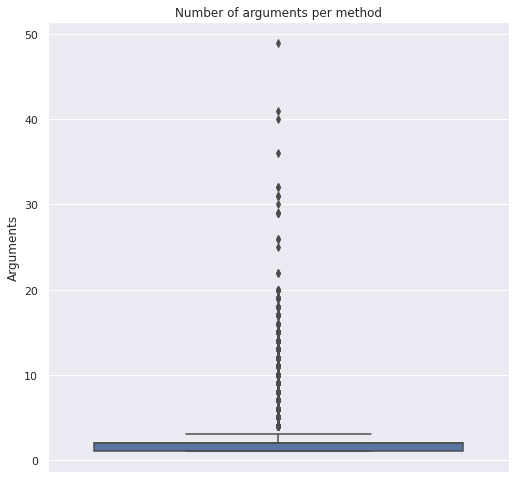

In [6]:
import seaborn as sns

sns.set(rc={'figure.figsize':(8.27,8.27)})
sns.set_style("darkgrid")
ax = sns.boxplot(y=data['arg_types'].apply(len).sort_values(ascending=False).iloc[1:], )
ax.set(ylabel='Arguments', title='Number of arguments per method')

/home/deadman445/anaconda3/envs/torchdimplom/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='repo'>

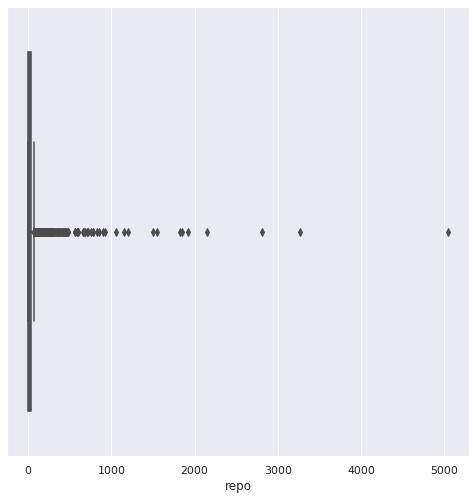

In [8]:
sns.boxplot(data.repo.value_counts())

(0.0, 100.0)

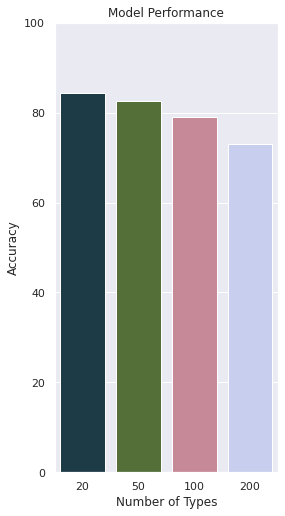

In [9]:
sns.set(rc={'figure.figsize':(4,8.27)})

ax = sns.barplot(x=[20,50,100,200],y=[84.3, 82.5, 79, 73], palette='cubehelix')
ax.set(ylabel='Accuracy', title='Model Performance', xlabel='Number of Types')
ax.set_ylim(0,100)

In [ ]:
df_labels.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).iloc[1:].index

[Text(0, 0.5, 'Number of arguments with type'),
 Text(0.5, 0, 'Type'),
 Text(0.5, 1.0, 'Number of arguments with type')]

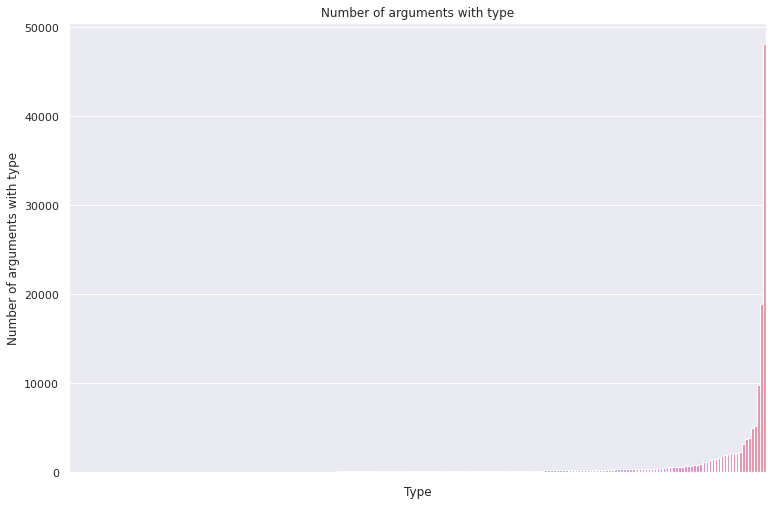

In [10]:
sns.set(rc={'figure.figsize':(12.5,8.27)})

ax = sns.barplot(x= df_labels.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).iloc[1:], y=df_labels.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).iloc[1:])


ax.set_xticklabels('')
ax.set(ylabel='Number of arguments with type', xlabel='Type', title='Number of arguments with type')

In [7]:
def remove_composite(p):
    a = []
    for i in p:
        if 'tuple' in i.lower():
            a.append(i)
            continue
        if '[' in i and not 'Union' in i:
            b = i.split('[')                
            if 'Optional' == b[0]:
                if len(b)>1:
                    a.append(b[1].split(']')[0].lower())
                else:
                    a.append(b[0].lower())
            else:
                a.append(b[0].lower())
        else:
            if i=='List' or i=='Dict' or i=='Callable':
                a.append(i.lower())                
            else:
                a.append(i.split('.')[-1])
    return a

def replace_type(df, typ='str', frac=0.9):
    df2= df.copy()
    str_cvrt = func(typ)
    df2.update(df[df.eq(typ).any(axis=1)].sample(frac=frac).apply(str_cvrt))
    return df2


def func(typ):
    def cvrt(p):
        a = []
        for i in p:
            if i == typ:
                a.append(FREQ_CUT_SYMBOL)
            else:
                a.append(i)
        return a
    return cvrt

dd = df_labels.apply(remove_composite)
for (k,v) in dict(dd.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)).items():
    if k!=FREQ_CUT_SYMBOL and k!=NaN_symbol and v>MAX_CUT:
        dd = replace_type(dd, k, (v-MAX_CUT)/v) 
df_labels = dd
df_labels = dd
dd.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).head(15).astype(int)

                 5515939
<UNK>              74765
list                6051
dict                6020
bool                6005
str                 5977
int                 5941
Any                 5653
float               5232
callable            3335
Path                2759
HttpRequest         2234
HomeAssistant       2223
UserProfile         2148
iterable            2072
dtype: int64

In [8]:
def la(data_batch_i):
    r = []
    
    for i in data_batch_i:
        if not (i == NaN_enc[0] or i==FREQ_CUT_ENC[0] or i==Any_enc[0]):
            r.append(i)
        if i==FREQ_CUT_ENC[0] or i==Any_enc[0]:
            r.append(NaN_enc[0])
    if len(r) == 0 or sum(r)==0:
        return pd.NA
    return r

df_labels = df_labels.apply(lambda x: x.mask(x.map(x.value_counts())<FREQ_LIMIT, FREQ_CUT_SYMBOL))
enc = preprocessing.LabelEncoder()
all_types = df_labels.apply(pd.Series).stack().values
enc.fit(all_types)
FREQ_CUT_ENC = enc.transform([FREQ_CUT_SYMBOL])
NaN_enc = enc.transform([NaN_symbol])
Any_enc = enc.transform(['Any'])
print(enc.inverse_transform(NaN_enc), enc.inverse_transform(FREQ_CUT_ENC))
print(f'Enc for "NaN" {NaN_enc}, Enc for FREQ_CUT_SYMBOL {FREQ_CUT_ENC}')
df3 = df_labels.apply(enc.transform)
data['labels'] = df3.values.tolist()

data['labels'] = data['labels'].apply(la)
data = data.dropna(subset=['labels'], axis=0)



def train_test_by_repo(data, split=0.75):
    train_l = []
    test_l = []
    c = 0
    train_len = split * len(data)
    for name, i in data.groupby(['repo']).count().sample(frac=1).iterrows():
        if train_len > c:
            train_l.append(name)
            c += i['author']
        else:
            test_l.append(name)
    return data.loc[data['repo'].isin(train_l)], data.loc[data['repo'].isin(test_l)]



train_ds, test_ds = train_test_by_repo(data, TRAIN_TEST_SPLIT)


len(enc.classes_)

[''] ['<UNK>']
Enc for "NaN" [0], Enc for FREQ_CUT_SYMBOL [2]


102

In [9]:
with open("types.txt", 'w') as f:
    for i in enc.classes_:
        f.write(i)
        f.write('\n')

In [10]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: GeForce RTX 2060 SUPER


In [11]:
bert.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [12]:
def process_elem(data_batch_i):
    sentence_line =  tokenizer(data_batch_i['body'], return_tensors='pt', padding='max_length', truncation=True)
    sentence_line1 = tokenizer(data_batch_i['body'], padding='max_length', truncation=True,  return_offsets_mapping=True, return_length=True)
    args = get_names(data_batch_i['body'])
    labels = dict(zip([i[0] for i in args], data_batch_i['labels']))
    args = offset2ind(args, sentence_line1)
    ids = torch.zeros_like(sentence_line['input_ids'])
    for i in args:
        ids[0][i[1]]=labels.get(i[0], NaN_enc[0])
    return sentence_line, ids

def offset2ind(args, tokens):
    def find(tok, lis):
        r = []
        for i in lis:
            if i[0]>=tok[1][0] and i[1]<=tok[1][1]:
                r.append(i)
                break
        b = [lis.index(i) for i in r]
        return b
    return [(i[0], find(i,tokens['offset_mapping'])) for i in args]


def get_names(src):
    ret = []
    line_lengths = [len(i) for i in src.split('\n')]
    line_lengths = [0] + line_lengths
    for i in range(1,len(line_lengths)):
        line_lengths[i] += line_lengths[i-1]+1
    
    try:
        for node in ast.walk(ast.parse(src)):
            if isinstance(node, ast.arg):
                ret.append((node.arg,(line_lengths[node.lineno-1]+node.col_offset, line_lengths[node.lineno-1]+node.end_col_offset)))
        return ret
    except:
        print("Could Not process the code")
        return ret
    

In [13]:
class JITDataDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data_batch = self.data.iloc[idx, :]
        full_sentence, ids = process_elem(data_batch)
        return (full_sentence['input_ids'].squeeze().to(device),
                full_sentence['attention_mask'].squeeze().to(device),
                (ids > 0).squeeze().to(device),
                ids.squeeze().to(device))

In [17]:
train = DataLoader(JITDataDataset(train_ds), batch_size=8,
                        shuffle=True)

In [16]:
class JITModel(torch.nn.Module):
    def __init__(self, bert, out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.bert = bert
#         
        self.dense = nn.Linear(768, out_dim)

    def forward(self, a,b,c,d):
        
        emb = self.bert(a, attention_mask=b)[0]
        out = self.dense(emb)
        mask = c.unsqueeze(-1).expand(out.size())
        masked = torch.masked_select(out, mask).reshape(len(torch.masked_select(d, c)),self.out_dim)
        return F.softmax(masked)
#          masked


model = JITModel(bert, len(enc.classes_))
model.to(device)
print()

In [14]:
cpu = torch.device("cpu")
a = next(iter(test))
model.to(cpu)
model.bert.to(cpu)
model.bert = torch.jit.trace(model.bert, (a[0].to(cpu), a[1].to(cpu)))

traced_model = torch.jit.script(model)
torch.jit.save(traced_model, "latest_bert_tune.pt")

NameError: name 'test' is not defined

In [19]:
i=7
for name, param in bert.named_parameters():                                            
    if f'encoder.layer.{i}' in name:
        param.requires_grad = True
        i+=1
    else:
        param.requires_grad = False

In [16]:
for param in model.bert.parameters():
    param.requires_grad = False

In [25]:
opti = torch.optim.Adam(model.parameters(), lr = 1e-6)
pbar = tqdm(total=len(train))
losses = []
accuracy = []
for i,a in enumerate(train):
    out = model.forward(a[0], a[1], a[2], a[3])
    
#     mask = a[2].unsqueeze(-1).expand(out.size())
#     masked = torch.masked_select(out, mask).reshape(len(torch.masked_select(a[3], a[2])),len(enc.classes_))
    
    
    labels = torch.masked_select(a[3], a[2])
    loss = F.nll_loss(torch.log(out), labels)
    if i % 500==0:
        print(enc.inverse_transform(torch.argmax(out.cpu(), dim=1)), enc.inverse_transform(labels.cpu()))
    loss.backward()

    if torch.isnan(loss):
#         print(a)
        pass
    else:
        accuracy.append(sum(torch.argmax(out.detach(), dim=1) == labels)/len(labels))
        losses.append(loss.detach())
    opti.step()
    if i % 1 ==0:
        pbar.set_description(f"Loss : { sum(losses)/len(losses)}, acc: {sum(accuracy)/len(accuracy)}")
    pbar.update(1)
pbar.close()

  0%|          | 0/6285 [00:00<?, ?it/s]

<ipython-input-16-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


['float' 'dict' 'float' 'Path' 'bytes' 'dict' 'int' 'list' 'list' 'float'] ['datetime' 'dict' 'float' 'Path' 'bytes' 'dict' 'str' 'list' 'list' 'int']
['Params' 'str' 'bool' 'str' 'Session' 'bool' 'list' 'str' 'dict'] ['Params' 'str' 'bool' 'int' 'object' 'bool' 'set' 'str' 'mapping']
['dict' 'str' 'datetime' 'HomeAssistantType' 'list' 'bool' 'dict' 'list'] ['dict' 'bytes' 'datetime' 'HomeAssistantType' 'iterable' 'bool' 'bool'
 'list']
['HomeAssistant' 'dict' 'Tensor' 'str' 'Contract' 'dict' 'int' 'Params'
 'dict' 'ndarray' 'ndarray' 'ndarray' 'float'] ['HomeAssistant' 'list' 'iterable' 'str' 'str' 'dict' 'int' 'Parameters'
 'dict' 'Tensor' 'Tensor' 'Tensor' 'float']
['float' 'type' 'object' 'HomeAssistant' 'dict' 'bool' 'list' 'list'
 'bool' 'HomeAssistant' 'ConfigEntry' 'Session'] ['float' 'type' 'str' 'HomeAssistant' 'dict' 'bool' 'list' 'list' 'list'
 'HomeAssistant' 'ConfigEntry' 'Session']
['dict' 'dict' 'str' 'list' 'Element' 'Settings' 'int' 'bool' 'list'] ['T' 'dict' 'str' 'D

In [21]:
pr_av = lambda x : sum(x)/len(x)

In [22]:
test = DataLoader(JITDataDataset(test_ds), batch_size=1, num_workers=0)

In [26]:
pbar = tqdm(total=len(test))
test_top_5s = []
test_accuracy = []
test_losses = []
test_true = []
test_pred = []
for i,a in enumerate(test):
    out = model.forward(a[0], a[1], a[2], a[3])
    labels = torch.masked_select(a[3], a[2])
    loss = F.nll_loss(torch.log(out), labels)

    if torch.isnan(loss):
#         print(a)
        pass
    else:
        test_pred = test_pred + list(enc.inverse_transform(torch.argmax(out.cpu(), dim=1)))
        test_true = test_true + list(enc.inverse_transform(labels.cpu()))
        test_accuracy.append(sum(torch.argmax(out, dim=1) == labels).detach()/len(labels))
        test_losses.append(loss.detach())
        top5s = torch.topk(out, 5).indices
        correct_top5 = 0
        for i in range(len(labels)):
            if labels[i] in top5s[i]:
                correct_top5 += 1
        test_top_5s.append(correct_top5/len(labels))
    
    if i % 20 ==0:
        pbar.set_description(f"Loss : { pr_av(test_losses)}, acc: {pr_av(test_accuracy)}, top5s: {pr_av(test_top_5s)}")
    pbar.update(1)
pbar.close()

  0%|          | 0/5290 [00:00<?, ?it/s]

<ipython-input-16-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


In [27]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

print(classification_report(test_true, test_pred))

                        precision    recall  f1-score   support

                   AST       0.00      0.00      0.00         6
       AUTH_USER_MODEL       1.00      0.36      0.53        22
      ActiveConnection       1.00      1.00      1.00        15
                   App       0.00      0.00      0.00         0
           Application       0.00      0.00      0.00        16
        ArgumentParser       0.50      1.00      0.67         2
                Buffer       1.00      0.11      0.20        44
                Client       0.10      0.50      0.16         4
                Config       0.80      0.31      0.44        26
           ConfigEntry       0.96      1.00      0.98        24
            ConfigType       0.74      0.90      0.81        69
         Configuration       0.00      0.00      0.00         2
             Container       1.00      0.01      0.02        87
               Context       0.89      0.89      0.89        44
              Contract       0.00      

/home/deadman445/anaconda3/envs/torchdimplom/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deadman445/anaconda3/envs/torchdimplom/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deadman445/anaconda3/envs/torchdimplom/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

# Inference

In [34]:
    
def transform_to_model(method, dev):
    data_batch={'body':method, 'labels':[1]*len(get_names(method))}
    full_sentence, ids = process_elem(data_batch)
    return (full_sentence['input_ids'].to(dev),
            full_sentence['attention_mask'].to(dev),
            (ids > 0).to(dev),
            ids.to(dev))

def infer(model, method):
    a = transform_to_model(method, device)
    out = model.forward(a[0], a[1], a[2], a[3])
    ret = enc.inverse_transform(torch.argmax(out.cpu(), dim=1))
    top5s = torch.topk(out, 5).indices.cpu()
#     for i in top5s:
#         print("Top5: ",enc.inverse_transform(i))
    return ret

In [35]:
method='def func(age, street, name = (fun, 1, (2,3))):\n\
    if (name == "Vadim"):\n\
        print("smth is wrong")\n\
    else:\n\
        print("Navanyi")\n\
    print(age, street)\n\
    print(name, age, street)\n'
infer(model, method)

<ipython-input-13-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


array(['float', 'str', 'str'], dtype=object)

In [36]:
with open('file','r') as f:
    method = "\n".join(f.readlines())
infer(model, method)

<ipython-input-13-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


array(['int', 'str', 'list'], dtype=object)

In [49]:
romanov.iloc[2]

ents                            [[26, 30, str], [19, 24, object]]
cats                                                       [None]
replacements    [[4, 12, 1429698], [13, 17, 1430619], [38, 42,...
docstrings      [        """\n        CompletionItem Initializ...
arg_types                                           [str, object]
body            def __init__(self, value, desc = '', *args, **...
Name: 2, dtype: object

In [47]:
romanov.iloc[1]['body']

'def __new__(cls, value, *args, **kwargs) :\n        return super().__new__(cls, value)\n'

In [46]:
infer(model,romanov.iloc[1]['body'])

<ipython-input-13-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


array(['type', 'str', 'list', 'dict'], dtype=object)

'CC' вместо нее G

Gdef

):

G(

G==

pri vet    priv et

\\

"" а уменя нет



# Romanov dataset test

In [27]:

romanov = pd.read_json('./annotated_functios/functions_with_annotations.jsonl', lines=True)

rm_extra_ents = lambda i:[x[2] for x in i]
romanov['arg_types']=romanov['ents'].apply(rm_extra_ents)

romanov['body']=romanov['text']
del romanov['text']


In [37]:
romanov.iloc[:1]

,ents,cats,replacements,docstrings,arg_types,body
0,"[[36, 45, Union[int, float]], [25, 34, int]]",[str],"[[4, 24, 1429694], [54, 61, 642357], [84, 93, ...","[ """"""Generate an error message when the the...","[Union[int, float], int]","def generate_range_error(range_min, range_max)..."


In [28]:
def change_arg_types(line):
    args = get_names(line['body'])
    types = line['arg_types']
    args = [arg for arg in args if arg[0] not in ['self', 'args', 'kwargs']]
    if len(args)!=len(types):
        return pd.NA
    return line

romanov_consistent = romanov.apply(change_arg_types, axis=1).dropna()

In [29]:
df_labels = pd.DataFrame(romanov_consistent['arg_types'].values.tolist())
df_labels[pd.isnull(df_labels)]  = NaN_symbol

dd = df_labels.apply(remove_composite)
for (k,v) in dict(dd.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)).items():
    if k!=FREQ_CUT_SYMBOL and k!=NaN_symbol and v>MAX_CUT:
        dd = replace_type(dd, k, (v-MAX_CUT)/v) 
df_labels = dd
df_labels = dd
dd.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).head(15)

                     73916.0
str                    677.0
int                    366.0
bool                   263.0
Any                    125.0
callable                93.0
dict                    76.0
bytes                   65.0
Description             51.0
float                   48.0
list                    48.0
sequence                45.0
Union[str, bytes]       31.0
T                       29.0
ndarray                 29.0
dtype: float64

In [30]:
le_dict = dict(zip(enc.classes_, enc.transform(enc.classes_)))
label_encode = lambda i:[le_dict.get(x, NaN_enc[0]) for x in i]



romanov_consistent['labels']=dd.apply(label_encode).values.tolist()

romanov_consistent['labels'] = romanov_consistent['labels'].apply(la)
romanov_consistent = romanov_consistent.dropna(subset=['labels'], axis=0)

romanov_loader = DataLoader(JITDataDataset(romanov_consistent), batch_size=1, num_workers=0)

In [37]:
romanov.shape

(3340, 6)

In [38]:
romanov_consistent.shape

(2330, 7)

In [31]:
pbar = tqdm(total=len(romanov_loader))
r_top_5s = []
r_accuracy = []
r_losses = []

r_true = []
r_pred = []



for i,a in enumerate(romanov_loader):
    out = model.forward(a[0], a[1], a[2], a[3])
    labels = torch.masked_select(a[3], a[2])
    loss = F.nll_loss(torch.log(out), labels)

    if torch.isnan(loss):
        # print(a)\n",
        pass
    else:
        r_pred = r_pred + list(enc.inverse_transform(torch.argmax(out.cpu(), dim=1)))
        r_true = r_true + list(enc.inverse_transform(labels.cpu()))
        if i%50==0:
            print(enc.inverse_transform(torch.argmax(out.cpu(), dim=1)), enc.inverse_transform(labels.cpu()))
        r_accuracy.append(sum(torch.argmax(out, dim=1) == labels).detach()/len(labels))
        r_losses.append(loss.detach())
        top5s = torch.topk(out, 5).indices
        correct_top5 = 0
        for i in range(len(labels)):
            if labels[i] in top5s[i]:
                correct_top5 += 1
        r_top_5s.append(correct_top5/len(labels))
    
    if i % 20 ==0:
        pbar.set_description(f"Loss : { pr_av(r_losses)}, acc: {pr_av(r_accuracy)}, top5s: {pr_av(r_top_5s)}")
    pbar.update(1)
pbar.close()

  0%|          | 0/949 [00:00<?, ?it/s]

<ipython-input-13-77c050f7d939>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(masked)


['float'] ['int']
['str'] ['str']
['bool' 'str' 'bool' 'bool'] ['bool' 'str' 'bool' 'bool']
['bool' 'str'] ['str' 'str']
['dict'] ['str']
['str' 'list'] ['iterable' 'str']
['Tensor' 'int'] ['int' 'int']
['Tensor' 'int' 'int' 'int'] ['int' 'int' 'bool' 'str']
['dict'] ['int']
['Path' 'str' 'str'] ['str' 'str' 'str']
['callable'] ['sequence']
['str' 'list' 'int' 'int'] ['int' 'int' 'int' 'bool']
['Path'] ['callable']
['callable' 'callable'] ['str' 'bool']
['str' 'callable' 'int' 'callable' 'callable' 'callable' 'int'] ['callable' 'float' 'dict' 'float' 'float' 'int' 'list']
['Path' 'int' 'int'] ['int' 'int' 'str']
['Client' 'str'] ['str' 'str']
['type' 'int'] ['str' 'int']
['str'] ['str']


In [32]:
print(classification_report(r_true, r_pred,zero_division=0))

              precision    recall  f1-score   support

      Client       0.00      0.00      0.00         0
     Context       0.00      0.00      0.00         0
   DataFrame       0.16      0.75      0.26         8
     Element       0.00      0.00      0.00         0
     Message       0.00      0.00      0.00         0
   Namespace       0.02      0.33      0.04         3
        Node       0.00      0.00      0.00         0
        Path       0.00      0.00      0.00         0
     Request       0.00      0.00      0.00         0
      Tensor       0.00      0.00      0.00         0
        Text       0.00      0.00      0.00         0
        User       0.00      0.00      0.00         0
        bool       0.41      0.20      0.27       264
       bytes       0.48      0.43      0.46        65
    callable       0.31      0.29      0.30        93
    datetime       0.00      0.00      0.00         1
        dict       0.18      0.26      0.21        76
       float       0.33    

In [12]:
for v,i in romanov.iloc[:50].iterrows():
    print(i['body'])
    print(infer(model, i['body']), i['arg_types'])
    print('__________________________________________________-')

def generate_range_error(range_min, range_max) :

    err_str = "expected "

    if range_max == constants.INFINITY:
        err_str += "at least {} argument".format(range_min)

        if range_min != 1:
            err_str += "s"
    else:
        if range_min == range_max:
            err_str += "{} argument".format(range_min)
        else:
            err_str += "{} to {} argument".format(range_min, range_max)

        if range_max != 1:
            err_str += "s"

    return err_str

__________________________________________________-
def __new__(cls, value, *args, **kwargs) :
        return super().__new__(cls, value)

__________________________________________________-
def __init__(self, value, desc = '', *args, **kwargs) :

        super().__init__(*args, **kwargs)
        self.description = desc

__________________________________________________-
def __init__(self, is_method, is_completer, to_call):

        self.is_method = is_method
        self.is_completer = is_completer


In [73]:
r_enc = preprocessing.LabelEncoder()

df_labels = pd.DataFrame(romanov_consistent['arg_types'].values.tolist())
df_labels[pd.isnull(df_labels)]  = NaN_symbol
all_types = df_labels.apply(pd.Series).stack().values
r_enc.fit(all_types)

LabelEncoder()

In [80]:
set(r_enc.classes_).intersection(set(enc.classes_))

{'',
 'Any',
 'DataFrame',
 'Type',
 'bool',
 'bytes',
 'dict',
 'float',
 'int',
 'list',
 'object',
 'str',
 'type'}